In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
import torch.utils.data as utils

In [3]:
import time
import tqdm
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
import torch.utils.data as utils
import torch.nn.init as init
from torch.autograd import Variable
import sys
sys.path.append("../new_flows")
from flows import RealNVP, Planar, MAF
from models import NormalizingFlowModel
import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal
from models import NormalizingFlowModel

In [5]:
import multiprocessing
num_available_cpus = multiprocessing.cpu_count()

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device =", device)
torch.set_default_tensor_type('torch.cuda.FloatTensor') if torch.cuda.is_available() else print ('cpu')

torch.set_num_threads(num_available_cpus)

print(torch.get_num_threads())
print(torch.get_num_interop_threads())

Device = cuda:0
16
8


In [7]:
#plt.style.use('ggplot')

In [8]:
class model_result():
    
    def __init__(self, prefix, sigloss, bkgloss, aetype):
        self.sigloss = np.load(prefix+'_'+sigloss+'.npy')
        self.bkgloss = np.load(prefix+'_'+bkgloss+'.npy')
        self.aetype = aetype

        
    def get_tpr_fpr(self):
        bins = np.linspace(0,10000,100001)
        tpr = []
        fpr = []
        for cut in bins:
            if self.aetype == 'sig':
                tpr.append(np.where(self.sigloss<cut)[0].shape[0]/len(self.sigloss))
                fpr.append(np.where(self.bkgloss<cut)[0].shape[0]/len(self.bkgloss))
            if self.aetype == 'bkg':
                tpr.append(np.where(self.sigloss>cut)[0].shape[0]/len(self.sigloss))
                fpr.append(np.where(self.bkgloss>cut)[0].shape[0]/len(self.bkgloss))
        

        return tpr,fpr
    
    def get_precision_recall(self):
        bins = np.linspace(0,1000,10001)
        tpr = []
        fpr = []
        precision = []
        for cut in bins:
            if self.aetype == 'sig':
                tpr.append(np.where(self.sigloss<cut)[0].shape[0]/len(self.sigloss))
                precision.append((np.where(self.sigloss<cut)[0].shape[0])/(np.where(self.bkgloss<cut)[0].shape[0]+np.where(self.sigloss<cut)[0].shape[0]))
            
            if self.aetype == 'bkg':
                tpr.append(np.where(self.sigloss>cut)[0].shape[0]/len(self.sigloss))
                precision.append((np.where(self.sigloss>cut)[0].shape[0])/(np.where(self.bkgloss>cut)[0].shape[0]+np.where(self.sigloss>cut)[0].shape[0]))
        

        return precision,tpr  

    def FPRat95TPR(self):
        tprs, fprs = get_tpr_fpr(self)
        for i in range(len(tprs)-1):
            if (tprs[i] < 0.95) and (tprs[i+1] >= 0.95):
                return fprs[i+1]

    def FPRat99TPR(self):
        tprs, fprs = get_tpr_fpr(self)
        for i in range(len(tprs) - 1):
            if (tprs[i] < 0.99) and (tprs[i + 1] >= 0.99):
                return fprs[i+1]    

In [9]:
num_features = 12
NS_hidden_features = 48
flow_type = 'MAF' #Options are 'MAF', 'Planar' (not recommended), 'NSQUAD', and 'NSRATQUAD'

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device =", device)

Device = cuda:0


In [11]:
#### MAF / Planar / NSQUAD / NSRATQUAD
class VAE_NF(nn.Module):
    def __init__(self, K, D):
        super().__init__()
        self.dim = D
        self.K = K
        self.encoder = nn.Sequential(
            nn.Linear(12, 50),
            nn.LeakyReLU(True),
            nn.Linear(50, 30),
            nn.LeakyReLU(True),
            nn.Linear(30, 20),
            nn.LeakyReLU(True),
            nn.Linear(20, D * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(D, 20),
            nn.LeakyReLU(True),
            nn.Linear(20, 30),
            nn.LeakyReLU(True),
            nn.Linear(30, 50),
            nn.LeakyReLU(True),
            nn.Linear(50, 12)
        )
        
        if flow_type == 'NSQUAD' or flow_type == 'NSRATQUAD': 
            #----- BEGIN NEW NEURAL SPLINE CODE
            
            bkg_transforms = []
            for _ in range(K):
                bkg_transforms.append(ReversePermutation(features=D))
                if flow_type == 'NSQUAD': 
                    bkg_transforms.append(MaskedPiecewiseQuadraticAutoregressiveTransform(features=D, 
                                                                      hidden_features=NS_hidden_features, tail_bound = 3.0, tails='linear'))
                elif flow_type == 'NSRATQUAD': 
                    bkg_transforms.append(MaskedPiecewiseRationalQuadraticAutoregressiveTransform(features=D, 
                                                                      hidden_features=NS_hidden_features, tail_bound = 3.0, tails='linear'))

            #bkg_transform = CompositeTransform(bkg_transforms)
            bkg_base_dist = MultivariateNormal(torch.zeros(D).cuda(), torch.eye(D).cuda())
            self.flows = NormalizingFlowModel(bkg_base_dist, bkg_transforms)
            #print(self.flows)
            
            #----- END NEW NEURAL SPLINE CODE
        
        elif flow_type == 'MAF' or flow_type == 'Planar': 
            if flow_type == 'MAF': 
                flow_init = MAF(dim=D)
            elif flow_type == 'Planar': 
                flow_init = Planar(dim=D)
            flows_init = [flow_init for _ in range(K)]
            prior = MultivariateNormal(torch.zeros(D).cuda(), torch.eye(D).cuda())
            self.flows = NormalizingFlowModel(prior, flows_init)
            #print(self.flows)
        
        else: 
            print('ERROR: Flow Type not properly specified.')

    def forward(self, x):
        # Run Encoder and get NF params
        enc = self.encoder(x)
        mu = enc[:, :self.dim]
        log_var = enc[:, self.dim: self.dim * 2]

        # Re-parametrize
        sigma = (log_var * .5).exp()
        z = mu + sigma * torch.randn_like(sigma)
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        # Construct more expressive posterior with NF
        
        z_k, _, sum_ladj = self.flows(z)
        
        kl_div = kl_div / x.size(0) - sum_ladj.mean()  # mean over batch

        # Run Decoder
        x_prime = self.decoder(z_k)
        return x_prime, kl_div

# PARAMETER OPTIMIZATION

In [12]:
class model_result(object):
    
    def __init__(self, prefix, aetype):
        self.sigloss = np.load(prefix+'_'+sigloss+'.npy')
        self.bkgloss = np.load(prefix+'_'+bkgloss+'.npy')
        self.aetype = aetype

        
    def get_tpr_fpr(self):
        bins = np.linspace(0,10000,100001)
        tpr = []
        fpr = []
        for cut in bins:
            if self.aetype == 'sig':
                tpr.append(np.where(self.sigloss<cut)[0].shape[0]/len(self.sigloss))
                fpr.append(np.where(self.bkgloss<cut)[0].shape[0]/len(self.bkgloss))
            if self.aetype == 'bkg':
                tpr.append(np.where(self.sigloss>cut)[0].shape[0]/len(self.sigloss))
                fpr.append(np.where(self.bkgloss>cut)[0].shape[0]/len(self.bkgloss))
        

        return tpr,fpr
    
    def get_precision_recall(self):
        bins = np.linspace(0,1000,10001)
        tpr = []
        fpr = []
        precision = []
        for cut in bins:
            if self.aetype == 'sig':
                tpr.append(np.where(self.sigloss<cut)[0].shape[0]/len(self.sigloss))
                precision.append((np.where(self.sigloss<cut)[0].shape[0])/(np.where(self.bkgloss<cut)[0].shape[0]+np.where(self.sigloss<cut)[0].shape[0]))
            
            if self.aetype == 'bkg':
                tpr.append(np.where(self.sigloss>cut)[0].shape[0]/len(self.sigloss))
                precision.append((np.where(self.sigloss>cut)[0].shape[0])/(np.where(self.bkgloss>cut)[0].shape[0]+np.where(self.sigloss>cut)[0].shape[0]))
        

        return precision,tpr  

    def FPRat95TPR(self):
        tprs, fprs = get_tpr_fpr(self)
        for i in range(len(tprs)-1):
            if (tprs[i] < 0.95) and (tprs[i+1] >= 0.95):
                return fprs[i+1]

    def FPRat99TPR(self):
        tprs, fprs = get_tpr_fpr(self)
        for i in range(len(tprs) - 1):
            if (tprs[i] < 0.99) and (tprs[i + 1] >= 0.99):
                return fprs[i+1]    

In [13]:
version = 0
#lrs = [5e-3, 1e-3,5e-4, 1e-4,1e-5,1e-6,1e-7]

In [14]:

bkg_mean = [229.63703733315916,
 0.5040889514020693,
 0.7057013083107537,
 0.7997482828680078,
 1.962088799505638,
 255.28311110430732,
 104.75378636669201,
 0.5826962213587913,
 0.7337977883611374,
 0.7995755223103627,
 2.4171146383976034,
 159.75951298419648]

bkg_std = [131.99460164832075,
 0.1849760683347428,
 0.12816197632833803,
 0.0865553075423761,
 0.7978444985340304,
 111.36202699158525,
 68.17314726646633,
 0.17458368821556094,
 0.11581000682757887,
 0.08481896882883566,
 1.1084488583498446,
 83.52566008451547]


# Prepping test dataset

In [16]:
#f_bkg = pd.read_hdf('~/QUASAR/preprocessing/conventional_tau_rnd.h5')
#f_sig = pd.read_hdf('~/QUASAR/preprocessing/delphes_output_4500_500_150.h5')
f_bb = pd.read_hdf('/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB1_rnd.h5')

In [16]:
dt = f_bkg.values
correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0)
dt = dt[correct]

correct = (dt[:,0]>=2800)
dt = dt[correct]   

for i in range(13,19):
    dt[:,i] = dt[:,i]/dt[:,3]

for i in range(29,35):
    dt[:,i] = dt[:,i]/(dt[:,19])
    
idx = dt[:,-1]
bkgidx = (idx == 0)
dt = dt[bkgidx]

bkg_mass = np.ndarray.tolist(dt[:,0])
print(bkg_mass[:25])
df = pd.DataFrame(bkg_mass) 
df.to_csv('csv_files/bkg_mass.csv')

Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]] 

print(Y.shape)

#for i in range(12):
#    Y[:,i] = (Y[:,i]-bkg_mean[i])/bkg_std[i]

bkg_mean = []
bkg_std = []

for i in range(12):
    mean = np.mean(Y[:,i])
    std = np.std(Y[:,i])
    bkg_mean.append(mean)
    bkg_std.append(std)
    Y[:,i] = (Y[:,i]-mean)/std

bkg_test = torch.tensor(Y)

[3807.507389467033, 2934.55791415029, 2951.902185699044, 3165.060459635266, 4033.2203792627615, 2897.629887620787, 3643.5097776813154, 3260.180625454622, 3023.248904055104, 3031.1493493613248, 3169.6200525717927, 4028.9677578619117, 3837.250861068567, 3324.948755924668, 3052.2607115189753, 4188.232597231751, 2802.8896721529118, 2878.186919180534, 2840.490579923818, 4255.72071198218, 3297.2048452651698, 3125.412526967946, 2999.841780655154, 3708.696377676113, 3655.570259947979]
(587907, 12)


In [17]:
bkg_mean

[229.63703733315916,
 0.5040889514020693,
 0.7057013083107537,
 0.7997482828680078,
 1.962088799505638,
 255.28311110430732,
 104.75378636669201,
 0.5826962213587913,
 0.7337977883611374,
 0.7995755223103627,
 2.4171146383976034,
 159.75951298419648]

In [18]:
bkg_std

[131.99460164832075,
 0.1849760683347428,
 0.12816197632833803,
 0.0865553075423761,
 0.7978444985340304,
 111.36202699158525,
 68.17314726646633,
 0.17458368821556094,
 0.11581000682757887,
 0.08481896882883566,
 1.1084488583498446,
 83.52566008451547]

In [19]:
dt = f_sig.values
correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0)
dt = dt[correct]

correct = (dt[:,0]>=2800)
dt = dt[correct]   

for i in range(13,19):
    dt[:,i] = dt[:,i]/dt[:,3]

for i in range(29,35):
    dt[:,i] = dt[:,i]/(dt[:,19])

correct = (dt[:,3]>200)  & (dt[:,19]>50) & (dt[:,0]>4200) & (dt[:,0]<4800)
#correct = (dt[:,3]>450) & (dt[:,3]<550) & (dt[:,19]>100) & (dt[:,19]<200) & (dt[:,0]>4200) & (dt[:,0]<4800)
dt = dt[correct]  

sig_mass = np.ndarray.tolist(dt[:,0])
print(sig_mass[:25])
df = pd.DataFrame(sig_mass) 
df.to_csv('csv_files/sig_mass.csv')

Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]

print(Y.shape)
#for i in range(12):
#    Y[:,i] = (Y[:,i]-bkg_mean[i])/bkg_std[i]

for i in range(12):
    Y[:,i] = (Y[:,i]-bkg_mean[i])/bkg_std[i]

sig_test = torch.tensor(Y)

[4285.984789956599, 4377.503176278464, 4485.604240957131, 4294.785162475908, 4385.016801440671, 4331.648288525545, 4448.66013835033, 4439.320723336695, 4483.770951908371, 4580.19838395949, 4544.99690558516, 4410.356462341254, 4538.491213300887, 4563.461686230372, 4287.965054991883, 4568.4185164827595, 4320.374991178084, 4535.262800196654, 4478.906126136756, 4441.925936527397, 4611.62557562622, 4606.102888989514, 4289.232616721781, 4518.506040766013, 4286.761411276158]
(39630, 12)


In [20]:
def get_tpr_fpr(sigloss,bkgloss):
    bins = np.linspace(0,100,1001)
    tpr = []
    fpr = []
    for cut in bins:
        tpr.append(np.where(sigloss>cut)[0].shape[0]/len(sigloss))
        fpr.append(np.where(bkgloss>cut)[0].shape[0]/len(bkgloss))


    return tpr,fpr

In [21]:
import re

In [22]:
Z_DIM = 4
N_FLOWS = 10
betas = [10.0]
beta = betas[0]

In [23]:
tprlist = []
fprlist = []
namelist = []
bkgtr_siglosslist = []
bkgtr_bkglosslist = []
tprlist_forinverse = []
fprinverselist = []

model = VAE_NF(N_FLOWS, Z_DIM).cuda()
model.load_state_dict(torch.load(f"/home/mikaeelyunus/QUASAR/weights/sangeon_bkg_model.h5"), strict=False)
#NOTE: Replace the /home/mikaeelyunus/ above with the directory in which QUASAR resides.
ae_def = {
            "type":"bkg",
            "trainon":"rndbkg",
            "features":"12features",
            "architecture":flow_type,
            "selection":"mjjcut",
            "trainloss":"MSELoss",
            "beta":f"beta{re.sub('[.,]', 'p', str(beta))}",
            "zdimnflow":f"z{Z_DIM}f{N_FLOWS}",
            "version":f"ver{version}"

         }
model.eval()
with torch.no_grad():
    sig_loss = torch.mean((model(sig_test.float().cuda())[0]- sig_test.float().cuda())**2,dim=1).data.cpu().numpy()
    bkg_loss = torch.mean((model(bkg_test.float().cuda())[0]- bkg_test.float().cuda())**2,dim=1).data.cpu().numpy()
    #sig_loss = torch.mean((model(sig_test.float().cuda())[0]- sig_test.float().cuda())**2,dim=1).data.cpu().numpy() + beta * F.kl_div(model(sig_test.float().cuda())[0], sig_test.float().cuda()).cpu().numpy()
    #bkg_loss = torch.mean((model(bkg_test.float().cuda())[0]- bkg_test.float().cuda())**2,dim=1).data.cpu().numpy() + beta * F.kl_div(model(bkg_test.float().cuda())[0], bkg_test.float().cuda()).cpu().numpy()

np.save(f"/home/mikaeelyunus/QUASAR/data_strings/sangeon_bkg_model_sigloss.npy",sig_loss)
#NOTE: Replace the /home/mikaeelyunus/ above with the directory in which QUASAR resides.
np.save(f"/home/mikaeelyunus/QUASAR/data_strings/sangeon_bkg_model_bkgloss.npy",bkg_loss)
#NOTE: Replace the /home/mikaeelyunus/ above with the directory in which QUASAR resides.

namelist.append(ae_def)
tpr, fpr = get_tpr_fpr(sig_loss,bkg_loss)
tprlist.append(tpr)
fprlist.append(fpr)
tpr_np, fpr_np = np.array(tpr), np.array(fpr)

nonzero_idx = np.nonzero(fpr_np)


bkgtr_siglosslist.append(sig_loss)
bkgtr_bkglosslist.append(bkg_loss)

tprlist_forinverse.append(tpr_np[nonzero_idx])
fprinverselist.append(1/fpr_np[nonzero_idx])



In [24]:
namelist

[{'type': 'bkg',
  'trainon': 'rndbkg',
  'features': '12features',
  'architecture': 'MAF',
  'selection': 'mjjcut',
  'trainloss': 'MSELoss',
  'beta': 'beta10p0',
  'zdimnflow': 'z4f10',
  'version': 'ver0'}]

In [25]:
for index in range(len(betas)): 
        
    bkgtr_bkgloss = bkgtr_bkglosslist[index]
    bkgtr_sigloss = bkgtr_siglosslist[index]
    
    df_bkgloss = pd.DataFrame(bkgtr_bkgloss)
    df_sigloss = pd.DataFrame(bkgtr_sigloss)
    df_bkgloss.to_csv('csv_files/sangeon_bkg_model_bkgloss.csv') 
    df_sigloss.to_csv('csv_files/sangeon_bkg_model_sigloss.csv')  

In [26]:
plt.rcParams["figure.figsize"] = (8,8)
from sklearn import metrics

beta10p0_z4f10 17.27422634924233


(0.0, 1.0)

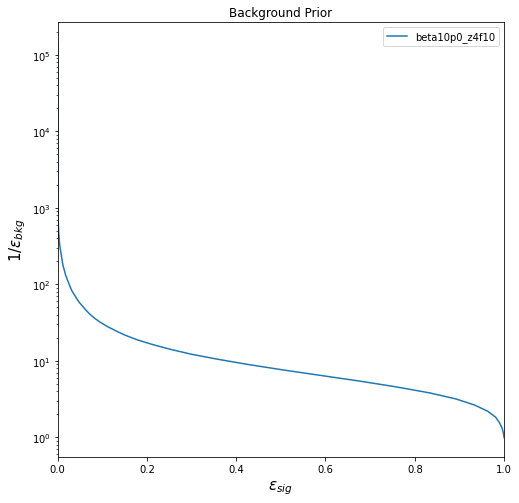

In [27]:
for tpr, fpr, name,sigloss,bkgloss in zip(tprlist_forinverse,fprinverselist, namelist,bkgtr_siglosslist,bkgtr_bkglosslist):
    #if name['beta'] == 'beta10p0' or name['beta'] == 'beta2p0':
    if name['zdimnflow'] == 'z4f10':
        #print(tpr, fpr)
        plt.plot(tpr,fpr, label=f"{name['beta']}_{name['zdimnflow']}")
        print(f"{name['beta']}_{name['zdimnflow']}",metrics.auc(fpr,tpr))
        #plt.hist(sigloss,np.arange(0,10,0.1),alpha=0.2, density=True, label=f"{name['beta']}_{name['zdimnflow']}")
        #plt.hist(bkgloss,np.arange(0,10,0.1),alpha=0.2, density=True, label=f"{name['beta']}_{name['zdimnflow']}")
plt.xlabel(r'$\epsilon_{sig}$',fontsize=15)
plt.ylabel(r'$1/\epsilon_{bkg}$',fontsize=15)
#plt.semilogy()
plt.yscale('log')

plt.title('Background Prior')
#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.legend(loc='upper right')
plt.xlim([0.0,1.0])
#plt.ylim([0.0,1.0])
#plt.savefig('ROC_effectiveness_of_quak.png')

beta10p0_z4f10 0.8382966581302318


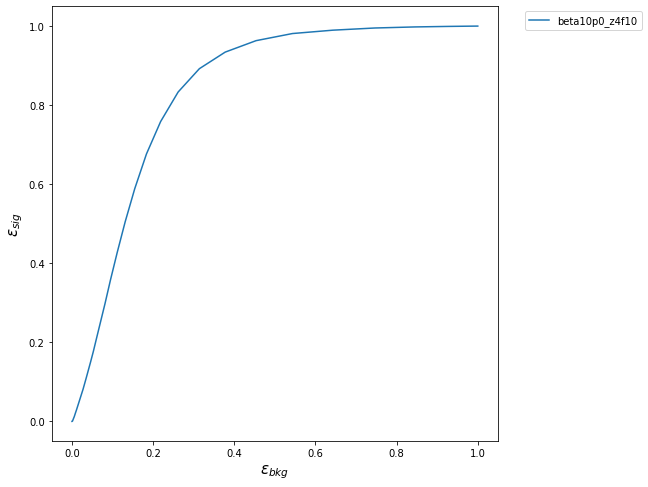

In [28]:
for tpr, fpr, name,sigloss,bkgloss in zip(tprlist,fprlist, namelist,bkgtr_siglosslist,bkgtr_bkglosslist):
    #if name['beta'] == 'beta10p0' or name['beta'] == 'beta2p0':
    if name['zdimnflow'] == 'z4f10':
        plt.plot(fpr,tpr, label=f"{name['beta']}_{name['zdimnflow']}")
        print(f"{name['beta']}_{name['zdimnflow']}",metrics.auc(fpr,tpr))
        #plt.hist(sigloss,np.arange(0,10,0.1),alpha=0.2, density=True, label=f"{name['beta']}_{name['zdimnflow']}")
        #plt.hist(bkgloss,np.arange(0,10,0.1),alpha=0.2, density=True, label=f"{name['beta']}_{name['zdimnflow']}")
plt.xlabel(r'$\epsilon_{bkg}$',fontsize=15)
plt.ylabel(r'$\epsilon_{sig}$',fontsize=15)
#plt.semilogy()
#plt.yscale('log')

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
#plt.legend(loc='lower right')
#plt.xlim([0.05,1.0])
#plt.ylim([0.0,1.0])
#plt.savefig('ROC_effectiveness_of_quak.png')

# NOW SIGNAL AE

In [29]:
f_bkg = pd.read_hdf('~/QUASAR/preprocessing/conventional_tau_rnd.h5')
f_sig = pd.read_hdf('~/QUASAR/preprocessing/delphes_output_4500_500_150.h5')
f_bb = pd.read_hdf('~/QUASAR/preprocessing/conventional_tau_BB1_rnd.h5')

In [30]:
'''
sig_mean = [489.6699791129437,
 0.22463354907052815,
 0.639679230886038,
 0.7742464847783065,
 1.4122267488712905,
 253.95296492556145,
 167.8782919951573,
 0.3429350853771621,
 0.6460772390759577,
 0.7653966882661628,
 1.4541020071952622,
 165.34100428967955]

sig_std = [66.87936517220672,
 0.1361910116638729,
 0.15309413231859276,
 0.10054671892302457,
 0.3833027691949484,
 87.45977372109115,
 50.53622336909848,
 0.14930126292179366,
 0.15096516491915418,
 0.10415175051343364,
 0.44297590229588857,
 55.44436453890166]
'''

'\nsig_mean = [489.6699791129437,\n 0.22463354907052815,\n 0.639679230886038,\n 0.7742464847783065,\n 1.4122267488712905,\n 253.95296492556145,\n 167.8782919951573,\n 0.3429350853771621,\n 0.6460772390759577,\n 0.7653966882661628,\n 1.4541020071952622,\n 165.34100428967955]\n\nsig_std = [66.87936517220672,\n 0.1361910116638729,\n 0.15309413231859276,\n 0.10054671892302457,\n 0.3833027691949484,\n 87.45977372109115,\n 50.53622336909848,\n 0.14930126292179366,\n 0.15096516491915418,\n 0.10415175051343364,\n 0.44297590229588857,\n 55.44436453890166]\n'

In [31]:
dt = f_sig.values
correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0)
dt = dt[correct]

correct = (dt[:,0]>=2800)
dt = dt[correct]   

for i in range(13,19):
    dt[:,i] = dt[:,i]/dt[:,3]

for i in range(29,35):
    dt[:,i] = dt[:,i]/(dt[:,19])

correct = (dt[:,3]>200)  & (dt[:,19]>50) & (dt[:,0]>4200) & (dt[:,0]<4800)
#correct = (dt[:,3]>450) & (dt[:,3]<550) & (dt[:,19]>100) & (dt[:,19]<200) & (dt[:,0]>4200) & (dt[:,0]<4800)
dt = dt[correct]  

Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]

#for i in range(12):
#    Y[:,i] = (Y[:,i]-sig_mean[i])/sig_std[i]

sig_mean = []
sig_std = []

for i in range(12):
    mean = np.mean(Y[:,i])
    std = np.std(Y[:,i])
    sig_mean.append(mean)
    sig_std.append(std)
    Y[:,i] = (Y[:,i]-mean)/std

print(Y.shape)

sig_test = torch.tensor(Y)

(39630, 12)


In [32]:
sig_mean

[489.6699791129437,
 0.22463354907052815,
 0.639679230886038,
 0.7742464847783065,
 1.4122267488712905,
 253.95296492556145,
 167.8782919951573,
 0.3429350853771621,
 0.6460772390759577,
 0.7653966882661628,
 1.4541020071952622,
 165.34100428967955]

In [33]:
sig_std

[66.87936517220672,
 0.1361910116638729,
 0.15309413231859276,
 0.10054671892302457,
 0.3833027691949484,
 87.45977372109115,
 50.53622336909848,
 0.14930126292179366,
 0.15096516491915418,
 0.10415175051343364,
 0.44297590229588857,
 55.44436453890166]

In [34]:
dt = f_bkg.values
correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0)
dt = dt[correct]

correct = (dt[:,0]>=2800)
dt = dt[correct]   

for i in range(13,19):
    dt[:,i] = dt[:,i]/dt[:,3]

for i in range(29,35):
    dt[:,i] = dt[:,i]/(dt[:,19])


idx = dt[:,-1]
bkgidx = (idx == 0)
dt = dt[bkgidx]

Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]

#for i in range(12):
#    Y[:,i] = (Y[:,i]-sig_mean[i])/sig_std[i]

for i in range(12):
    Y[:,i] = (Y[:,i]-sig_mean[i])/sig_std[i]

bkg_test = torch.tensor(Y)

In [35]:
print(sig_test)

tensor([[-0.0676,  0.2178,  0.3771,  ..., -0.3123,  0.8996, -1.3949],
        [-0.4486, -0.7038,  0.9860,  ...,  1.3597, -0.0731, -0.8899],
        [ 0.6613, -1.0283,  1.0687,  ..., -0.2467, -0.7173,  0.1201],
        ...,
        [ 0.1977,  0.8943, -0.8374,  ...,  0.3510,  9.2257, -1.3949],
        [-0.6551,  0.8781, -0.7417,  ...,  0.4030, -0.6633,  1.7073],
        [-0.1513, -1.0322,  0.8679,  ..., -1.5917,  1.6032, -1.6835]],
       dtype=torch.float64)


In [36]:
def get_tpr_fpr(sigloss,bkgloss):
    bins = np.linspace(0,200,4001)
    tpr = []
    fpr = []
    for cut in bins:
        tpr.append(np.where(sigloss<cut)[0].shape[0]/len(sigloss))
        fpr.append(np.where(bkgloss<cut)[0].shape[0]/len(bkgloss))


    return tpr,fpr

In [37]:
tprlist = []
fprlist = []
namelist = []
sigtr_siglosslist = []
sigtr_bkglosslist = []
tprlist_forinverse = []
fprinverselist = []

model = VAE_NF(N_FLOWS, Z_DIM).cuda()
#NOTE: The "architecture" key below can be set to "MAF", "Planar" (not recommended), "NSQUAD", or "NSRATQUAD". 
ae_def = {
            "type":"sig",
            "trainon":"2prong",
            "features":"12features",
            "architecture":flow_type,
            "selection":"mjjcut",
            "trainloss":"MSELoss",
            "beta":f"beta{re.sub('[.,]', 'p', str(beta))}",
            "zdimnflow":f"z{Z_DIM}f{N_FLOWS}",
            "version":f"ver{version}"

         }

model.load_state_dict(torch.load(f"/home/mikaeelyunus/QUASAR/weights/sangeon_sig_model.h5"), strict=False)
#NOTE: Replace the /home/mikaeelyunus/ above with the directory in which QUASAR resides.
model.eval()
with torch.no_grad():
    sig_loss = torch.mean((model(sig_test.float().cuda())[0]- sig_test.float().cuda())**2,dim=1).data.cpu().numpy()
    bkg_loss = torch.mean((model(bkg_test.float().cuda())[0]- bkg_test.float().cuda())**2,dim=1).data.cpu().numpy()
    #sig_loss = torch.mean((model(sig_test.float().cuda())[0]- sig_test.float().cuda())**2,dim=1).data.cpu().numpy() + beta * F.kl_div(model(sig_test.float().cuda())[0], sig_test.float().cuda()).cpu().numpy()
    #bkg_loss = torch.mean((model(bkg_test.float().cuda())[0]- bkg_test.float().cuda())**2,dim=1).data.cpu().numpy() + beta * F.kl_div(model(bkg_test.float().cuda())[0], bkg_test.float().cuda()).cpu().numpy()


np.save(f"/home/mikaeelyunus/QUASAR/data_strings/sangeon_sig_model_sigloss.npy",sig_loss)
#NOTE: Replace the /home/mikaeelyunus/ above with the directory in which QUASAR resides.
np.save(f"/home/mikaeelyunus/QUASAR/data_strings/sangeon_sig_model_bkgloss.npy",bkg_loss)
#NOTE: Replace the /home/mikaeelyunus/ above with the directory in which QUASAR resides.

namelist.append(ae_def)
tpr, fpr = get_tpr_fpr(sig_loss,bkg_loss)
tprlist.append(tpr)
fprlist.append(fpr)
tpr_np, fpr_np = np.array(tpr), np.array(fpr)

nonzero_idx = np.nonzero(fpr_np)


sigtr_siglosslist.append(sig_loss)
sigtr_bkglosslist.append(bkg_loss)

tprlist_forinverse.append(tpr_np[nonzero_idx])
fprinverselist.append(1/fpr_np[nonzero_idx])

In [38]:
for index in range(len(betas)): 
        
    sigtr_bkgloss = sigtr_bkglosslist[index]
    sigtr_sigloss = sigtr_siglosslist[index]
    
    df_bkgloss = pd.DataFrame(sigtr_bkgloss)
    df_sigloss = pd.DataFrame(sigtr_sigloss)
    df_bkgloss.to_csv('csv_files/sangeon_sig_model_bkgloss.csv') 
    df_sigloss.to_csv('csv_files/sangeon_sig_model_sigloss.csv')

beta10p0_z4f10 3363.7414912254044


(0.0, 1.0)

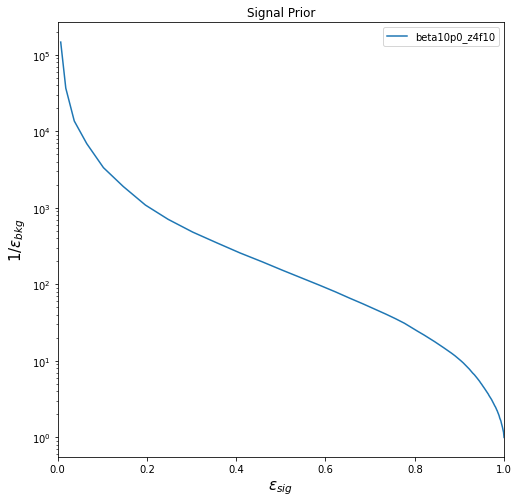

In [39]:
for tpr, fpr, name,sigloss,bkgloss in zip(tprlist_forinverse,fprinverselist, namelist,sigtr_siglosslist,sigtr_bkglosslist):
    #if name['beta'] == 'beta10p0' or name['beta'] == 'beta2p0':
    if name['zdimnflow'] == 'z4f10':
        #print(tpr, fpr)
        plt.plot(tpr,fpr, label=f"{name['beta']}_{name['zdimnflow']}")
        print(f"{name['beta']}_{name['zdimnflow']}",metrics.auc(fpr,tpr))
        #plt.hist(sigloss,np.arange(0,10,0.1),alpha=0.2, density=True, label=f"{name['beta']}_{name['zdimnflow']}")
        #plt.hist(bkgloss,np.arange(0,10,0.1),alpha=0.2, density=True, label=f"{name['beta']}_{name['zdimnflow']}")
plt.xlabel(r'$\epsilon_{sig}$',fontsize=15)
plt.ylabel(r'$1/\epsilon_{bkg}$',fontsize=15)
#plt.semilogy()
plt.yscale('log')

plt.title('Signal Prior')
#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.legend(loc='upper right')
plt.xlim([0.0,1.0])
#plt.ylim([0.0,1.0])
#plt.savefig('ROC_effectiveness_of_quak.png')

beta10p0_z4f10 0.9607194372971632


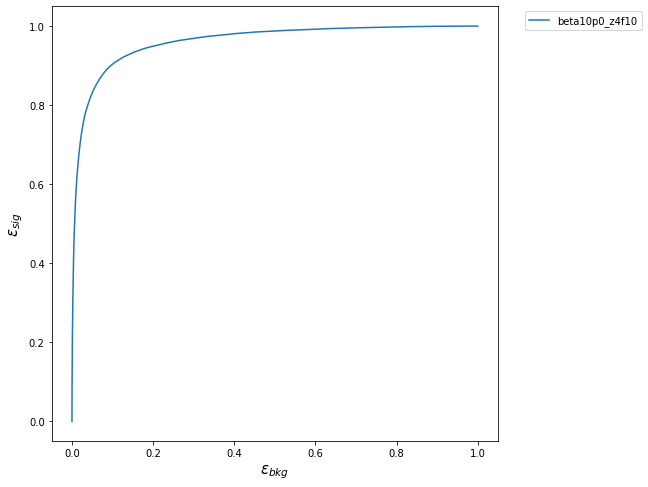

In [40]:
for tpr, fpr, name,sigloss,bkgloss in zip(tprlist,fprlist, namelist,sigtr_siglosslist,sigtr_bkglosslist):
    #if name['beta'] == 'beta10p0' or name['beta'] == 'beta2p0':
    if name['zdimnflow'] == 'z4f10':
        plt.plot(fpr,tpr, label=f"{name['beta']}_{name['zdimnflow']}")
        print(f"{name['beta']}_{name['zdimnflow']}",metrics.auc(fpr,tpr))
        #plt.hist(sigloss,np.arange(0,10,0.1),alpha=0.2, density=True, label=f"{name['beta']}_{name['zdimnflow']}")
        #plt.hist(bkgloss,np.arange(0,10,0.1),alpha=0.2, density=True, label=f"{name['beta']}_{name['zdimnflow']}")
plt.xlabel(r'$\epsilon_{bkg}$',fontsize=15)
plt.ylabel(r'$\epsilon_{sig}$',fontsize=15)
#plt.semilogy()
#plt.yscale('log')

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
#plt.legend(loc='lower right')
#plt.xlim([0.05,1.0])
#plt.ylim([0.0,1.0])
#plt.savefig('ROC_effectiveness_of_quak.png')

# Black Box Testing

In [39]:
#f_bkg = pd.read_hdf('~/QUASAR/preprocessing/conventional_tau_rnd.h5')
#f_sig = pd.read_hdf('~/QUASAR/preprocessing/delphes_output_4500_500_150.h5')
f_bb = pd.read_hdf('/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB1_rnd.h5')

In [40]:
dt = f_bb.values


In [41]:
dt.shape

(1000000, 35)

In [32]:
dt = f_bb.values
correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0)
dt = dt[correct]

correct = (dt[:,0]>=2800)
dt = dt[correct]   

for i in range(13,19):
    dt[:,i] = dt[:,i]/dt[:,3]

for i in range(29,35):
    dt[:,i] = dt[:,i]/(dt[:,19])

In [33]:
idx = dt[:,-1]


In [34]:
idx

array([0.00000000e+00, 5.94765825e-08, 1.15256917e-07, ...,
       0.00000000e+00, 9.06531874e-08, 0.00000000e+00])

In [35]:
bbidx = (idx == 0)


In [36]:
bbidx.shape

(488280,)

In [37]:
dt = dt[bbidx]


In [38]:
dt.shape

(106650, 35)

In [17]:
dt = f_bb.values
correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0)
dt = dt[correct]

correct = (dt[:,0]>=2800)
dt = dt[correct]   

for i in range(13,19):
    dt[:,i] = dt[:,i]/dt[:,3]

for i in range(29,35):
    dt[:,i] = dt[:,i]/(dt[:,19])

idx = dt[:,-1]
bbidx = (idx == 0)
dt = dt[bbidx]


Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]] 

for i in range(12):
    Y[:,i] = (Y[:,i]-bkg_mean[i])/bkg_std[i]

print(Y.shape)

print(Y[:25])
bb_test = torch.tensor(Y)

[3104.289128268278, 2843.8911922174857, 4160.290640349415, 4010.3573932424247, 3658.9887004344037, 3078.4289358916562, 3089.8179491089636, 3140.3669442866835, 4475.023899126603, 2998.71630953236, 3788.515501098005, 2916.6248780117794, 3357.162734415298, 3648.856204216617, 3190.971403974984, 2897.412974546544, 3322.0740764537854, 3419.7639604502983, 3195.6886349838956, 2993.8815252846457, 3441.8762574948473, 4868.554315322869, 3004.737205729325, 4163.025638413199, 3389.541400308394]


FileNotFoundError: [Errno 2] No such file or directory: 'csv_files/bb_mass.csv'

In [43]:
namelist = []
bkgtr_bblosslist = []

model = VAE_NF(N_FLOWS, Z_DIM).cuda()
#NOTE: The "architecture" key below can be set to "MAF", "Planar" (not recommended), "NSQUAD", or "NSRATQUAD". 
ae_def = {
            "type":"bkg",
            "trainon":"rndbkg",
            "features":"12features",
            "architecture":flow_type,
            "selection":"mjjcut",
            "trainloss":"MSELoss",
            "beta":f"beta{re.sub('[.,]', 'p', str(beta))}",
            "zdimnflow":f"z{Z_DIM}f{N_FLOWS}",
            "version":f"ver{version}"

         }
model.load_state_dict(torch.load(f"/home/mikaeelyunus/QUASAR/weights/sangeon_bkg_model.h5"), strict=False)
#NOTE: Replace the /home/mikaeelyunus/ above with the directory in which QUASAR resides.
model.eval()
with torch.no_grad():
    bb_loss = torch.mean((model(bb_test.float().cuda())[0]- bb_test.float().cuda())**2,dim=1).data.cpu().numpy() 
    #bb_loss = torch.mean((model(bb_test.float().cuda())[0]- bb_test.float().cuda())**2,dim=1).data.cpu().numpy() + beta * F.kl_div(model(bb_test.float().cuda())[0], bb_test.float().cuda()).cpu().numpy()

np.save(f"/home/mikaeelyunus/QUASAR/data_strings/sangeon_bkg_model_bbloss.npy",bb_loss)
#NOTE: Replace the /home/mikaeelyunus/ above with the directory in which QUASAR resides.

namelist.append(ae_def)

bkgtr_bblosslist.append(bb_loss)  
            

In [44]:
for index in range(len(betas)): 
        
    bkgtr_bbloss = bkgtr_bblosslist[index]
    
    df_bbloss = pd.DataFrame(bkgtr_bbloss)
    df_bbloss.to_csv('csv_files/sangeon_bkg_model_bbloss.csv')

In [45]:
dt = f_bb.values
correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0)
dt = dt[correct]

correct = (dt[:,0]>=2800)
dt = dt[correct]   

for i in range(13,19):
    dt[:,i] = dt[:,i]/dt[:,3]

for i in range(29,35):
    dt[:,i] = dt[:,i]/(dt[:,19])

idx = dt[:,-1]
bbidx = (idx == 0)
dt = dt[bbidx]

bb_mass = np.ndarray.tolist(dt[:,0])
print(bb_mass[:25])
df = pd.DataFrame(bb_mass) 
df.to_csv('csv_files/bb_mass.csv')

Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]] 

for i in range(12):
    Y[:,i] = (Y[:,i]-sig_mean[i])/sig_std[i]

print(Y.shape)

print(Y[:25])
bb_test = torch.tensor(Y)

[3104.289128268278, 2843.8911922174857, 4160.290640349415, 4010.3573932424247, 3658.9887004344037, 3078.4289358916562, 3089.8179491089636, 3140.3669442866835, 4475.023899126603, 2998.71630953236, 3788.515501098005, 2916.6248780117794, 3357.162734415298, 3648.856204216617, 3190.971403974984, 2897.412974546544, 3322.0740764537854, 3419.7639604502983, 3195.6886349838956, 2993.8815252846457, 3441.8762574948473, 4868.554315322869, 3004.737205729325, 4163.025638413199, 3389.541400308394]
(106650, 12)
[[-1.59295886e+00  2.62439450e+00 -1.94174867e+00 -9.49183083e-01
   2.96915931e-01  3.89287939e-01 -5.24262679e-01  1.66628467e+00
   1.74018774e+00  9.26371992e-01  1.15524485e+00  1.70727894e+00]
 [-5.77145047e+00  3.10949948e+00 -3.34004192e-02  9.77854519e-01
   3.22311345e+00 -9.37036096e-01 -2.86557928e+00  1.22033809e+00
   2.04747505e-01 -1.13040411e+00 -3.26320515e-01 -1.61136312e+00]
 [-6.09415082e+00  4.32375652e+00  8.33800563e-01 -5.92300173e-01
   9.16972607e+00 -1.80600702e+00 -2

In [46]:
namelist = []
sigtr_bblosslist = []

model = VAE_NF(N_FLOWS, Z_DIM).cuda()
#NOTE: The "architecture" key below can be set to "MAF", "Planar" (not recommended), "NSQUAD", or "NSRATQUAD". 
ae_def = {
            "type":"sig",
            "trainon":"2prong",
            "features":"12features",
            "architecture":flow_type,
            "selection":"mjjcut",
            "trainloss":"MSELoss",
            "beta":f"beta{re.sub('[.,]', 'p', str(beta))}",
            "zdimnflow":f"z{Z_DIM}f{N_FLOWS}",
            "version":f"ver{version}"

         }

model.load_state_dict(torch.load(f"/home/mikaeelyunus/QUASAR/weights/sangeon_sig_model.h5"), strict=False)
#NOTE: Replace the /home/mikaeelyunus/ above with the directory in which QUASAR resides.
model.eval()
with torch.no_grad():
    bb_loss = torch.mean((model(bb_test.float().cuda())[0] - bb_test.float().cuda())**2,dim=1).data.cpu().numpy()
    #bb_loss = torch.mean((model(bb_test.float().cuda())[0] - bb_test.float().cuda())**2,dim=1).data.cpu().numpy() + beta * F.kl_div(model(bb_test.float().cuda())[0], bb_test.float().cuda()).cpu().numpy()

#np.save(f"/home/mikaeelyunus/QUASAR/data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['architecture']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_{ae_def['version']}_sigloss.npy",sig_loss)
np.save(f"/home/mikaeelyunus/QUASAR/data_strings/sangeon_sig_model_bbloss.npy",bb_loss)
#NOTE: Replace the /home/mikaeelyunus/ above with the directory in which QUASAR resides.

namelist.append(ae_def)

sigtr_bblosslist.append(bb_loss)

In [47]:
for index in range(len(betas)): 
        
    sigtr_bbloss = sigtr_bblosslist[index]
    
    df_bbloss = pd.DataFrame(sigtr_bbloss)
    df_bbloss.to_csv('csv_files/sangeon_sig_model_bbloss.csv') 

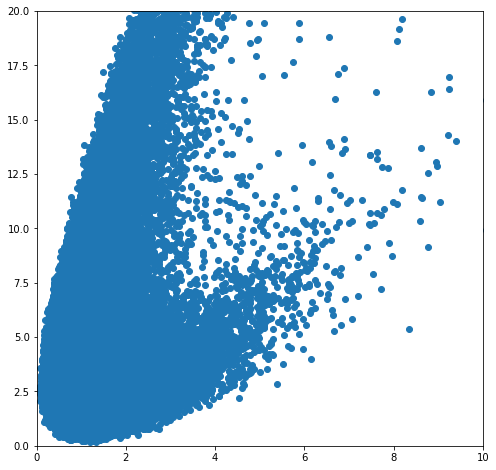

In [48]:
for index in range(len(betas)): 
    
    bkgtr_bbloss = bkgtr_bblosslist[index]
    sigtr_bbloss = sigtr_bblosslist[index]
    
    plt.scatter(bkgtr_bbloss, sigtr_bbloss)
    plt.xlim(0,10)
    plt.ylim(0,20)
    plt.show()

# 2D ROC Curves (Still in Development)

In [ ]:
from scipy.spatial import ConvexHull

def get_hull_coordinates(scan_tpr, scan_fpr):
    points = np.array([scan_fpr,scan_tpr])
    points = points.transpose()
    hull = ConvexHull(points)
    fpr = np.array(points[hull.vertices[:],0])
    tpr = np.array(points[hull.vertices[:],1])
    nonzero_idx = np.nonzero(fpr)
    fpr = fpr[nonzero_idx]
    tpr = tpr[nonzero_idx]
    return tpr, fpr 

def get_tpr_fpr_2d(sigae_sigloss,sigae_bkgloss,bkgae_sigloss,bkgae_bkgloss):
    bins_sigae = np.arange(0,30,0.1)
    bins_bkgae = np.arange(0,30,0.1)
    tpr = []
    fpr = []
    for sigcut in bins_sigae:
        for bkgcut in bins_bkgae:
            tpr_t = np.where((sigae_sigloss<sigcut)&(bkgae_sigloss>bkgcut))[0].shape[0]/len(sigae_sigloss)
            fpr_t = np.where((sigae_bkgloss<sigcut)&(bkgae_bkgloss>bkgcut))[0].shape[0]/len(sigae_bkgloss)
            tpr.append(tpr_t)
            fpr.append(fpr_t)
            
    tpr, fpr = get_hull_coordinates(tpr, fpr)
                

    return tpr,fpr

In [ ]:
tpr2dlist = []
fpr2dlist = []
tpr2dlist_forinverse = []
fpr2dinverselist = []
for SSLs, SBLs, BSLs, BBLs in zip(sigtr_siglosslist, sigtr_bkglosslist, bkgtr_siglosslist, bkgtr_bkglosslist):
    print(SSLs[:20])
    print(SBLs[:20])
    print(BSLs[:20])
    print(BBLs[:20])
    tpr2d, fpr2d = get_tpr_fpr_2d(SSLs, SBLs, BSLs, BBLs)
    print(tpr2d.shape)
    print(fpr2d.shape)
    tpr2dlist.append(tpr2d)
    fpr2dlist.append(fpr2d)
    tpr2d_np, fpr2d_np = np.array(tpr2d), np.array(fpr2d)

    nonzero_idx = np.nonzero(fpr2d_np)

    tpr2dlist_forinverse.append(tpr2d_np[nonzero_idx])
    fpr2dinverselist.append(1/fpr2d_np[nonzero_idx])

In [ ]:
for tpr2d, fpr2d, name in zip(tpr2dlist_forinverse,fpr2dinverselist, namelist):
    #if name['beta'] == 'beta10p0' or name['beta'] == 'beta2p0':
    if name['zdimnflow'] == 'z4f10':
        #print(tpr2d, fpr2d)
        print(tpr2d.shape, fpr2d.shape)
        plt.plot(tpr2d[1:],fpr2d[1:], label=f"{name['beta']}_{name['zdimnflow']}")
        #AUC Calculation below (buggy)
        #print(f"{name['beta']}_{name['zdimnflow']}",metrics.auc(fpr2d,tpr2d))
        #plt.hist(sigloss,np.arange(0,10,0.1),alpha=0.2, density=True, label=f"{name['beta']}_{name['zdimnflow']}")
        #plt.hist(bkgloss,np.arange(0,10,0.1),alpha=0.2, density=True, label=f"{name['beta']}_{name['zdimnflow']}")
plt.xlabel(r'$\epsilon_{sig}$',fontsize=15)
plt.ylabel(r'$1/\epsilon_{bkg}$',fontsize=15)
#plt.semilogy()
plt.yscale('log')

plt.title('Inverted 2D ROC')
#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.legend(loc='upper right')
plt.xlim([0.0,1.0])
#plt.ylim([0.0,1.0])
#plt.savefig('ROC_effectiveness_of_quak.png')

In [ ]:
for tpr2d, fpr2d, name in zip(tpr2dlist,fpr2dlist, namelist):
    #if name['beta'] == 'beta10p0' or name['beta'] == 'beta2p0':
    if name['zdimnflow'] == 'z4f10':
        plt.plot(fpr2d[1:],tpr2d[1:], label=f"{name['beta']}_{name['zdimnflow']}")
        #AUC calculation below (buggy)
        #print(f"{name['beta']}_{name['zdimnflow']}",metrics.auc(fpr2d,tpr2d))
        #plt.hist(sigloss,np.arange(0,10,0.1),alpha=0.2, density=True, label=f"{name['beta']}_{name['zdimnflow']}")
        #plt.hist(bkgloss,np.arange(0,10,0.1),alpha=0.2, density=True, label=f"{name['beta']}_{name['zdimnflow']}")
plt.xlabel(r'$\epsilon_{bkg}$',fontsize=15)
plt.ylabel(r'$\epsilon_{sig}$',fontsize=15)
#plt.semilogy()
#plt.yscale('log')

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
#plt.legend(loc='lower right')
#plt.xlim([0.05,1.0])
#plt.ylim([0.0,1.0])
#plt.savefig('ROC_effectiveness_of_quak.png')

# 2D QUAK Spaces (Still in Development)

In [ ]:
def multidim_cumsum(a):
    out = a.cumsum(-1)
    for i in range(2,a.ndim+1):
        np.cumsum(out, axis=-i, out=out)
    return out

def plot_cdf(inp_h_bkg, inp_h_sig, inp_X, inp_Y, inp_plot_lower_bound, inp_plot_upper_bound, num_bins = 50, save_cdfs = False): 

    bkg_cumulative_counts = multidim_cumsum(inp_h_bkg)
    sig_cumulative_counts = multidim_cumsum(inp_h_sig)
    
    cumulative_counts = sig_cumulative_counts/np.sqrt(bkg_cumulative_counts)
    flattened_cumulative_counts = cumulative_counts.flatten()

    h_bkg_sig, _, _, _ = plt.hist2d(inp_X, inp_Y, weights=flattened_cumulative_counts, cmap = plt.cm.jet, bins=num_bins)
    plt.colorbar()
    plt.xlabel("BKG-Trained Model Loss")
    plt.ylabel("SIG-Trained Model Loss")
    plt.title("S/sqrt(B) 2D Loss Histogram (CDF)")
    #plt.xlim(inp_plot_lower_bound, inp_plot_upper_bound)
    #plt.ylim(inp_plot_lower_bound, inp_plot_upper_bound)
    if save_cdfs: 
        print(filename)
        plt.savefig('cdfs/%s.png' % (filename))
    plt.show()

In [ ]:
reco_loss_only = True
x_bad_loss_cutoff = 7.5
y_bad_loss_cutoff = 7.5

for beta_index in range(len(bkgtr_siglosslist)): 

    beta_val = betas[beta_index]
    
    #------------------------------------------------------------------------------
    
    num_bins = 5000
    
    h_bkg, bkg_xedges, bkg_yedges, _ = plt.hist2d(bkgtr_bkglosslist[beta_index], sigtr_bkglosslist[beta_index], cmap = plt.cm.jet, bins=num_bins)
    plt.colorbar()
    plt.xlabel("BKG-Trained Model Loss")
    plt.ylabel("SIG-Trained Model Loss")
    plt.title("BKG Testing Data 2D Loss Histogram (PDF) (Beta = %s)" % (beta_val))
    plt.xlim(0, x_bad_loss_cutoff)
    plt.ylim(0, y_bad_loss_cutoff)
    plt.show()
    
    #------------------------------------------------------------------------------
    
    num_bins = 100
    
    beta_val = betas[beta_index]
    
    h_sig, sig_xedges, sig_yedges, _ = plt.hist2d(bkgtr_siglosslist[beta_index], sigtr_siglosslist[beta_index], cmap = plt.cm.jet, bins=num_bins)
    plt.colorbar()
    plt.xlabel("BKG-Trained Model Loss")
    plt.ylabel("SIG-Trained Model Loss")
    plt.title("SIG Testing Data 2D Loss Histogram (PDF) (Beta = %s)" % (beta_val))
    plt.xlim(0, x_bad_loss_cutoff)
    plt.ylim(0, y_bad_loss_cutoff)
    plt.show()
    
    #------------------------------------------------------------------------------

    num_bins = 1000
    save_cdfs = False

    x_lowest_bin_center = np.min(bkg_xedges) + (bkg_xedges[1]-bkg_xedges[0]) / 2

    x_highest_bin_center = np.max(bkg_xedges) - (bkg_xedges[1]-bkg_xedges[0]) / 2
    x_bin_step = (bkg_xedges[1]-bkg_xedges[0])

    y_lowest_bin_center = np.min(bkg_yedges) + (bkg_yedges[1]-bkg_yedges[0]) / 2
    y_highest_bin_center = np.max(bkg_yedges) - (bkg_yedges[1]-bkg_yedges[0]) / 2
    y_bin_step = (bkg_yedges[1]-bkg_yedges[0])

    h_bkg, bkg_xedges, bkg_yedges, _ = plt.hist2d(bkgtr_bkglosslist[beta_index], sigtr_bkglosslist[beta_index], cmap = plt.cm.jet, bins=num_bins)
    h_sig, sig_xedges, sig_yedges, _ = plt.hist2d(bkgtr_siglosslist[beta_index], sigtr_siglosslist[beta_index], cmap = plt.cm.jet, bins=num_bins)
    #print(h_bkg)
    #print(h_skg)

    counts = h_sig/np.sqrt(h_bkg)
    flattened_counts = counts.flatten()

    print(num_bins*x_bin_step)

    X,Y = np.mgrid[x_lowest_bin_center:x_highest_bin_center+x_bin_step:x_bin_step, y_lowest_bin_center:y_highest_bin_center+y_bin_step:y_bin_step]
    X = X[:num_bins, :num_bins]
    Y = Y[:num_bins, :num_bins]
    X = X.flatten()
    Y = Y.flatten()

    print(X.shape)
    print(Y.shape)
    print(counts.shape)
    print(flattened_counts.shape)

    h_bkg_sig, _, _, _ = plt.hist2d(X, Y, weights=flattened_counts, cmap = plt.cm.jet, bins=num_bins)
    plt.colorbar()
    plt.xlabel("BKG-Trained Model Loss")
    plt.ylabel("SIG-Trained Model Loss")
    plt.title("S/sqrt(B) 2D Loss Histogram (PDF)")
    plt.xlim(0, x_bad_loss_cutoff)
    plt.ylim(0, y_bad_loss_cutoff)
    plt.show()

    #------------------------------------------------------------------------------

    plot_cdf(h_bkg, h_sig, X, Y, 0, x_bad_loss_cutoff, num_bins=num_bins, save_cdfs=save_cdfs)